In [2241]:
import os
import sys
import string
from music21 import *
from itertools import chain, imap
import csv
import json
import random

In [2242]:
def fetch_genres(basedir):
    genres = []
    nested = os.listdir(basedir)
    for i in nested:
        try:
            if(os.path.isdir(i) and not i.startswith(".")):
                genres.append(i)
        except:
            print("An error occured trying to load features for genre " + i)
    return genres

In [2243]:
def chunks(l, n):
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

In [2244]:
def flatmap(l):
    return [item for sublist in l for item in sublist]

In [2245]:
def failed_features(basedir):
    not_included = set()
    fs = features.jSymbolic.extractorsById
    genres = fetch_genres(basedir)
    for genre in genres:
        try: 
            filename = basedir + "/" + genre + "/features"
            files = os.listdir(filename)
            for aFile in files:
                if aFile.endswith(".csv"):
                    arr = fileToArray(filename + "/" + aFile)
                    arr1 = set(map(lambda x: tuple(x[0:2]), arr))
                    # If features failed to extract 
                    for k in fs:
                        if k is not "I":
                            for i in range(len(fs[k])):
                                if (k,str(i)) not in arr1 and fs[k][i] is not None:
                                    not_included.add((k,i))
        except:
            print("An error occured trying to load features for genre " + genre)
    return not_included

In [2246]:
def build_vectors(exclude_features, basedir):
    genres = fetch_genres(basedir)
    final_vecs = []
    for genre in genres:
        try:
            filename = basedir + "/" + genre + "/features"
            files = os.listdir(filename)
            for aFile in files:
                vec = []
                if aFile.endswith(".csv"):
                    arr = fileToArray(filename + "/" + aFile)
                    for i in arr:
                        if (i[0], int(i[1])) not in exclude_features:
                            vec.append(map(lambda x: float(x), i[3:]))
                if len(vec) > 0:
                    final_vec = flatmap(vec)
                    final_vec.append(genre)
                    final_vecs.append(final_vec)
        except:
            print("Error occured trying to load features for " + genre)
    return final_vecs

In [2247]:
def fileToArray(filename):
    array = []
    with open(filename, 'rb') as f:
        reader = csv.reader(f)
        try:
            array = list(reader)
        except: 
            print("Error reading: " + filename)
    f.close()
    return array

In [2248]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=90)
    plt.yticks(tick_marks, genres)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [2249]:
def read_data():
    basedir = "."

    # Features that failed to extract will not be written to files. Put all the failed
    # features into a set so that they can be excluded from the final vectors right away.
    not_included = failed_features(basedir)

    # Vectors is a list of lists. The inner list contains the features and the resulting
    # labels in the last position of each vector. 
    vecs = build_vectors(not_included, basedir)
    
    return vecs


In [2250]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold


def select_features(X, y):

    clf = ExtraTreesClassifier()
    clf = clf.fit(X, y)
    importances = clf.feature_importances_ 
    model = SelectFromModel(clf, prefit=True)
    
    X_new = model.transform(X)

    ranks = []
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    for f in range(X_new.shape[1]):
        ranks.append((f + 1, indices[f], importances[indices[f]]))

    return (X_new, ranks)

In [2251]:
genres = fetch_genres(basedir)

Feature Rankings for run 0
(1, 153, 0.02089818184737503)
(2, 159, 0.015027727577606254)
(3, 157, 0.013267786431512866)
(4, 203, 0.013025950323417921)
(5, 221, 0.01143096348171962)
(6, 151, 0.010934673989807173)
(7, 144, 0.010447168048330265)
(8, 218, 0.010257997366177694)
(9, 223, 0.010162108729113127)
(10, 317, 0.0099824694843902197)
(11, 155, 0.0089923904556135064)
(12, 135, 0.0085587275569484131)
(13, 145, 0.0084694874066753752)
(14, 2, 0.0083342351697765944)
(15, 199, 0.008280728018509452)
(16, 211, 0.0082401041136096788)
(17, 134, 0.008225821100849625)
(18, 152, 0.0080763257118566939)
(19, 314, 0.0080695754385179501)
(20, 204, 0.0080220047890635603)
(21, 294, 0.0080133332939433775)
(22, 330, 0.0080085167015393113)
(23, 329, 0.0079767727434802808)
(24, 295, 0.0079527178005152546)
(25, 138, 0.0078084422353864981)
(26, 319, 0.0077683942142198646)
(27, 154, 0.0077430923407632562)
(28, 310, 0.0075488105985426577)
(29, 311, 0.0075269962898051488)
(30, 231, 0.0074915725308428837)
(31, 30

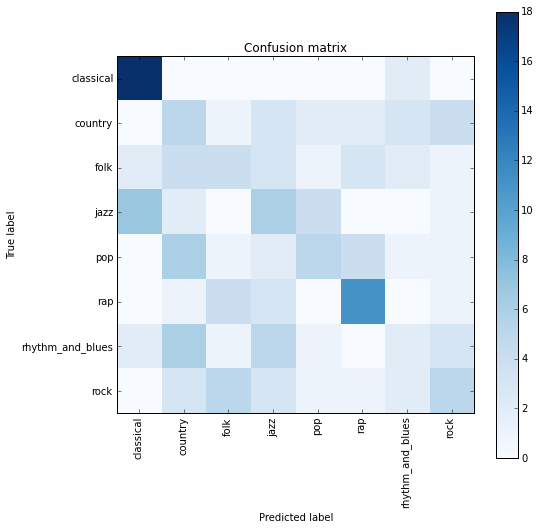

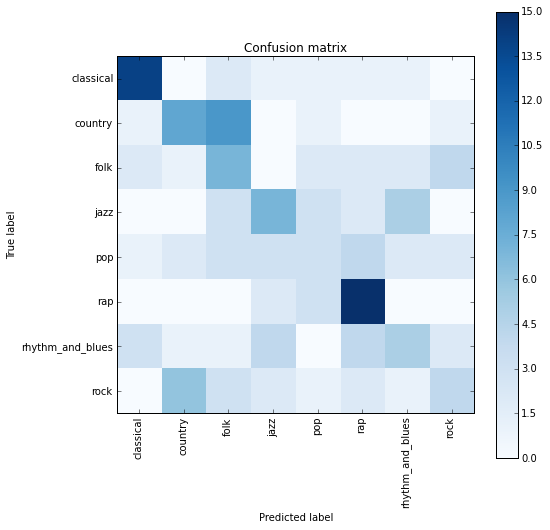

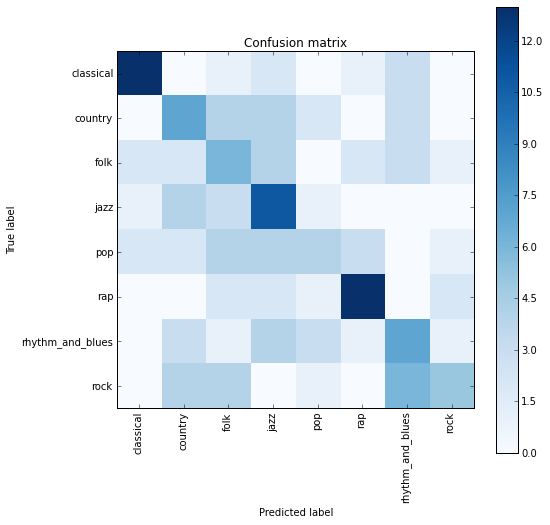

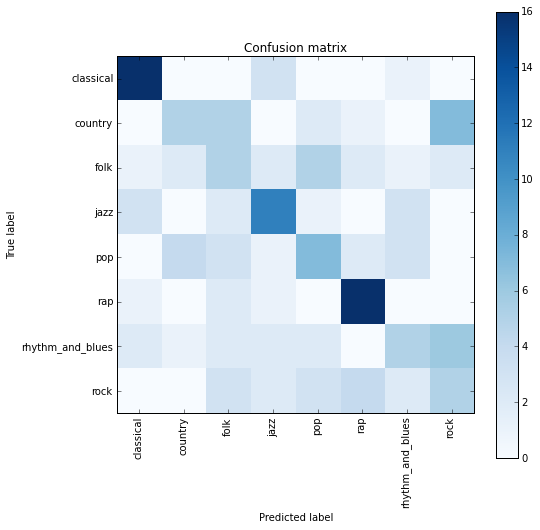

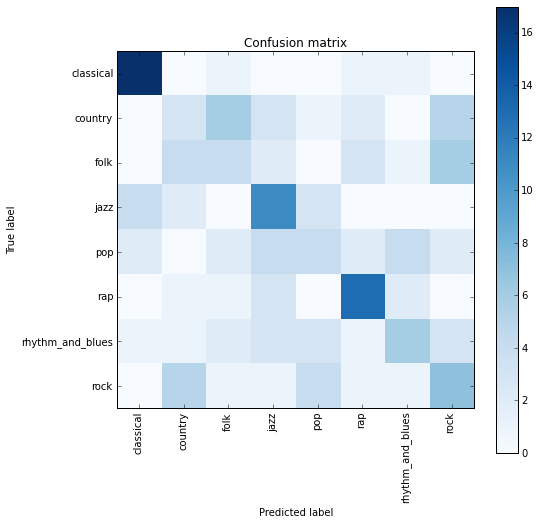

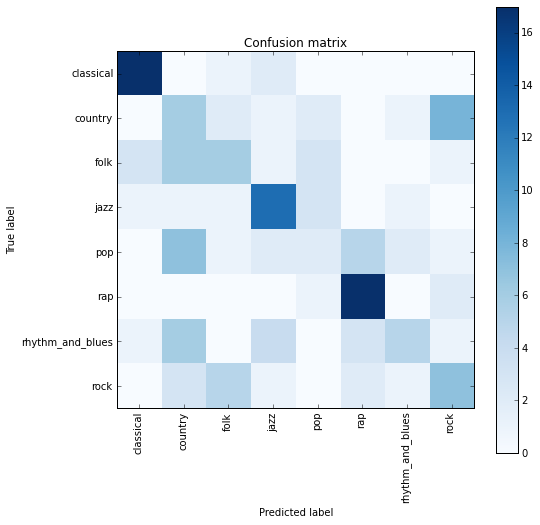

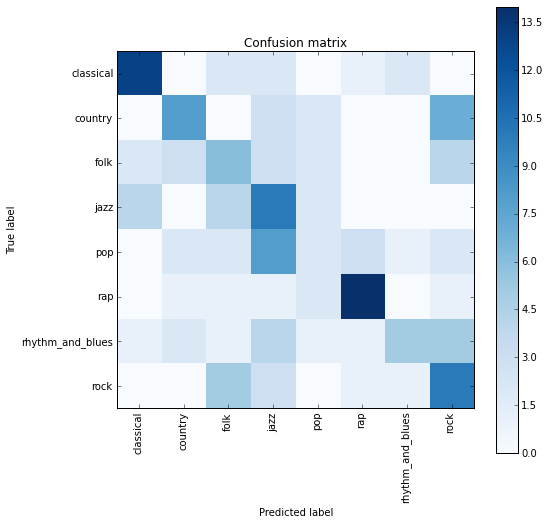

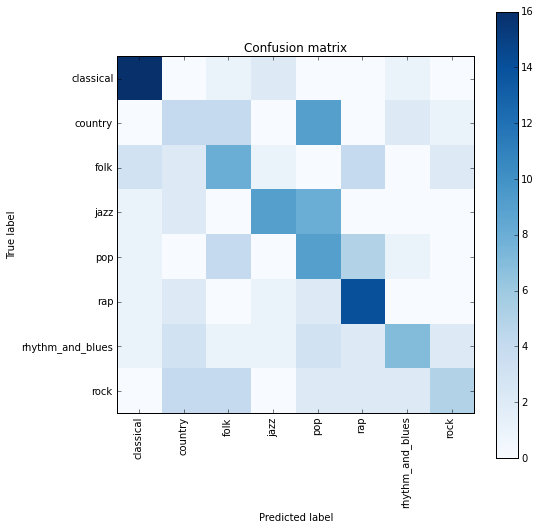

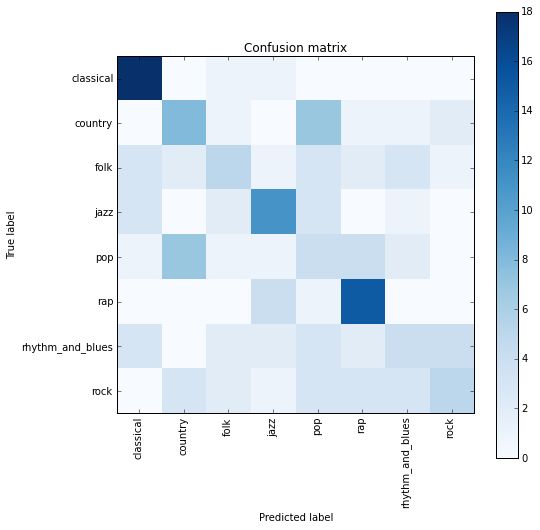

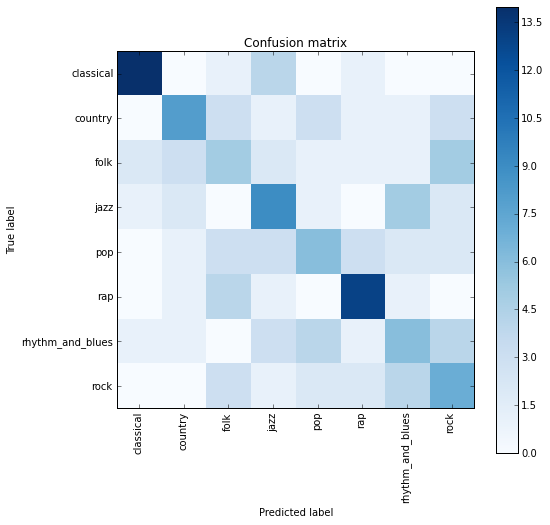

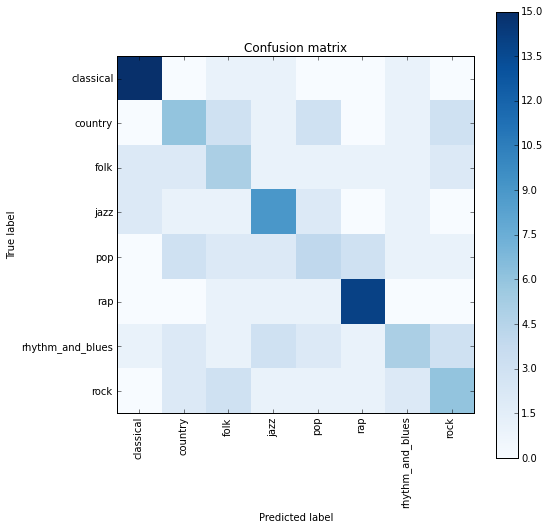

In [2252]:
matrices = []
accuracies = []

sel_features = []

for i in range(0,5):
    
    vecs = read_data()
    random.shuffle(vecs)
    
    X, y = map(lambda x: x[0:len(x)-1], vecs), map(lambda x: x[len(x)-1], vecs)
    
    selected = select_features(X, y)
    X_new = selected[0]
    
    sel_features.append(set(map(lambda x: x[1], selected[1])))
    
    print("Feature Rankings for run " + str(i))
    for rank in selected[1]:
        print(rank)
        
    print("")
    
    X_fin = np.array(X_new)
    Y_fin = np.array(y)
    
    kf = StratifiedKFold(Y_fin, 2)

    count = 0
    for train_index, test_index in kf:

        clf = RandomForestClassifier(n_estimators=100, random_state=0, criterion="entropy")
        clf = clf.fit(X_fin[train_index], Y_fin[train_index])

        X_test = X_fin[test_index]
        Y_test = Y_fin[test_index]

        Y_pred = clf.predict(X_test)

        cm = confusion_matrix(Y_test, Y_pred, genres)
        
        plot_confusion_matrix(cm)
        
        cr = classification_report(Y_test, Y_pred)
        
        print(str(cr))
        
        a_score = accuracy_score(Y_test, Y_pred, True)
        matrices.append(cm)
        accuracies.append(a_score)
    
# Average together the confusion matrix values
final_cf = []
for i in range(0, len(matrices[0])):
    final_cf.append([])
    for j in range(0, len(matrices[0])):

        sum = 0;
        for k in range(0, len(matrices)):
            sum += matrices[k][i][j]
        final_cf[i].append(sum / len(matrices))

sum = 0
for i in accuracies:
    sum += i


plot_confusion_matrix(final_cf)
print(str(sum / len(accuracies)))

print(str(len(sel_features[0])))
print(str(len(set.intersection(*sel_features))))